# Setup

In [1]:
# basic python package
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import os
import math

%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

In [2]:
# spark related
from pyspark.sql import DataFrameWriter
sql = sqlContext.sql

In [3]:
# spark context
sc.master

u'local[*]'

In [4]:
! ls ../../dataset/profile

ls: ../../dataset/profile: No such file or directory


# Profile

In [5]:
profile_path = os.path.abspath('../dataset/profile/**/*.csv')

In [6]:
profile_text = sc.textFile(profile_path)
profile_text.take(5)

[u'1,1083060338,F,I,292141,F,606063,3667420800,173.0289647440402,168.62583605184867,Y,Y,Y,Y,3696969600',
 u'2,2186820338,F,B,653673,B,122851,3291321600,200.84809884772136,1004.8535938607777,Y,Y,N,Y,3696969600',
 u'3,1966068338,M,D,373933,D,639201,3373574400,1589.205135410834,58.94475293467117,N,Y,N,N,3696969600',
 u'4,1650708338,M,D,39007,H,87913,3402950400,415.73561935499026,183.66420164840252,Y,Y,N,Y,3696969600',
 u'5,1335348338,F,G,254521,F,472657,3312921600,1225.8381529866247,3330.3261064497733,Y,Y,Y,Y,3696969600']

## Raw data to Spark Dataframe 

In [7]:
from pyspark.sql.types import *

fields = [
    StructField('customer_id', StringType(), False),
    StructField('birth_time', LongType(), True),
    StructField('gender', StringType(), True),
    StructField('contact_loc', StringType(), True),
    StructField('contact_code', StringType(), True),
    StructField('register_loc', StringType(), True),
    StructField('register_code', StringType(), True),
    StructField('start_time', LongType(), True),
    StructField('aum', DoubleType(), True),
    StructField('net_profit', DoubleType(), True),
    StructField('credit_card_flag', StringType(), True),
    StructField('loan_flag', StringType(), True),
    StructField('deposit_flag', StringType(), True),
    StructField('wealth_flag', StringType(), True),
    StructField('partition_time', LongType(), True)
]

schema = StructType(fields)

def process_profile_line(l):
    p = l.split(',')
    # for LongType
    for i in [1, 7, 14]:
        p[i] = int(p[i])
    # for DoubleType
    for i in [8, 9]:
        p[i] = float(p[i])
    return p

profile_df = profile_text \
    .map(process_profile_line) \
    .toDF(schema=schema)
    
profile_df.show(5)

+-----------+----------+------+-----------+------------+------------+-------------+----------+------------------+------------------+----------------+---------+------------+-----------+--------------+
|customer_id|birth_time|gender|contact_loc|contact_code|register_loc|register_code|start_time|               aum|        net_profit|credit_card_flag|loan_flag|deposit_flag|wealth_flag|partition_time|
+-----------+----------+------+-----------+------------+------------+-------------+----------+------------------+------------------+----------------+---------+------------+-----------+--------------+
|          1|1083060338|     F|          I|      292141|           F|       606063|3667420800| 173.0289647440402|168.62583605184867|               Y|        Y|           Y|          Y|    3696969600|
|          2|2186820338|     F|          B|      653673|           B|       122851|3291321600|200.84809884772136|1004.8535938607777|               Y|        Y|           N|          Y|    3696969600|


In [8]:
profile_df.count()

100

# Event - CCTXN

In [9]:
cctxn_text = sc.textFile(os.path.abspath('../dataset/cctxn/**/*.csv'))
cctxn_text.take(2)

[u'customer_id,4,purchase_consumption,3696975741,merchant_nbr,VUAFPKBFAIENYETOLYIX,credit_card,GPSHLCABRIQBVOKVCUNK,"{\\"action\\": {\\"txn_amt\\": 1173.4403405275684, \\"original_currency_code\\": \\"TWD\\"}, \\"object\\": {\\"merchant_category_code\\": \\"05971\\"}, \\"channel\\": {\\"card_type\\": \\"B\\", \\"card_level\\": \\"5\\"}}",3696969600,cc_txn',
 u'customer_id,29,purchase_consumption,3696975741,merchant_nbr,VUAFPKBFAIENYETOLYIX,credit_card,GPSHLCABRIQBVOKVCUNK,"{\\"action\\": {\\"txn_amt\\": 1173.4403405275684, \\"original_currency_code\\": \\"TWD\\"}, \\"object\\": {\\"merchant_category_code\\": \\"05971\\"}, \\"channel\\": {\\"card_type\\": \\"B\\", \\"card_level\\": \\"5\\"}}",3696969600,cc_txn']

In [10]:
import json

fields = [
    StructField('actor_type', StringType(), False),
    StructField('actor_id', StringType(), True),
    StructField('action_type', StringType(), True),
    StructField('action_time', LongType(), True),
    StructField('object_type', StringType(), True),
    StructField('object_id', StringType(), True),
    StructField('channel_type', StringType(), True),
    StructField('channel_id', StringType(), True),
    StructField('attrs', StringType(), True),
    StructField('partition_time', LongType(), True),
    StructField('theme', StringType(), True),
]

schema = StructType(fields)

def process_profile_line(l):
    p = l.split(',')
    # pre
    pre_fields = p[:8]
    pre_fields[3] = int(pre_fields[3])
    # post
    post_fields = p[-2:]
    post_fields[-2] = int(post_fields[-2])
    # attrs
    attrs = json.loads(','.join(p[8:-2]))
    # concat fields
    fields = pre_fields + [attrs] + post_fields
    return fields

cctxn_df = cctxn_text.map(process_profile_line).toDF(schema=schema)

cctxn_df.show(5)

+-----------+--------+--------------------+-----------+------------+--------------------+------------+--------------------+--------------------+--------------+------+
| actor_type|actor_id|         action_type|action_time| object_type|           object_id|channel_type|          channel_id|               attrs|partition_time| theme|
+-----------+--------+--------------------+-----------+------------+--------------------+------------+--------------------+--------------------+--------------+------+
|customer_id|       4|purchase_consumption| 3696975741|merchant_nbr|VUAFPKBFAIENYETOLYIX| credit_card|GPSHLCABRIQBVOKVCUNK|{"action": {"txn_...|    3696969600|cc_txn|
|customer_id|      29|purchase_consumption| 3696975741|merchant_nbr|VUAFPKBFAIENYETOLYIX| credit_card|GPSHLCABRIQBVOKVCUNK|{"action": {"txn_...|    3696969600|cc_txn|
|customer_id|      18|purchase_consumption| 3696975866|merchant_nbr|HJMGNAQEFRZMCIDBHLSR| credit_card|GOBOOQKAPKTNJLDLXXDI|{"action": {"txn_...|    3696969600|cc_txn

##  Use JSON process "attrs"

In [11]:
import json

# return to RDD for unstructured data
cctxn_attrs = cctxn_df.select("attrs").rdd.map(lambda r: r.attrs).map(lambda x: json.loads(x))
cctxn_attrs.take(3)

[{u'action': {u'original_currency_code': u'TWD',
   u'txn_amt': 1173.4403405275684},
  u'channel': {u'card_level': u'5', u'card_type': u'B'},
  u'object': {u'merchant_category_code': u'05971'}},
 {u'action': {u'original_currency_code': u'TWD',
   u'txn_amt': 1173.4403405275684},
  u'channel': {u'card_level': u'5', u'card_type': u'B'},
  u'object': {u'merchant_category_code': u'05971'}},
 {u'action': {u'original_currency_code': u'TWD',
   u'txn_amt': 177.63228741462754},
  u'channel': {u'card_level': u'3', u'card_type': u'B'},
  u'object': {u'merchant_category_code': u'03723'}}]

## Count the number of each card level 

In [12]:
cctxn_attrs.filter(lambda x: x['channel']['card_level'] is not None) \
    .map(lambda x: x['channel']['card_level']) \
    .map(lambda cl: (cl, 1)) \
    .reduceByKey(lambda x, y: x + y) \
    .sortBy(lambda x: -x[1]) \
    .collect()

[(u'3', 624), (u'4', 566), (u'5', 460), (u'2', 334), (u'6', 224), (u'1', 134)]

# Merge data from different theme

## ATM 

In [13]:
atm_df = sc.textFile(os.path.abspath('../dataset/atm/**/*.csv')) \
    .map(process_profile_line) \
    .toDF(schema=schema)

atm_df.show(5)

+-----------+--------+-----------+-----------+-----------+--------------------+------------+--------------------+--------------------+--------------+-----+
| actor_type|actor_id|action_type|action_time|object_type|           object_id|channel_type|          channel_id|               attrs|partition_time|theme|
+-----------+--------+-----------+-----------+-----------+--------------------+------------+--------------------+--------------------+--------------+-----+
|customer_id|      24|   transfer| 3696969655|saving_acct|RRQAIWQTVFEMFNHQRAKO|         ATM|BGZXUBVPWOQPFUBINYEW|{"action": {"txn_...|    3696969600|  atm|
|customer_id|      49|   transfer| 3696969655|saving_acct|RRQAIWQTVFEMFNHQRAKO|         ATM|BGZXUBVPWOQPFUBINYEW|{"action": {"txn_...|    3696969600|  atm|
|customer_id|       6|   withdraw| 3696971685|saving_acct|SICMEBNJDHPWWCVZJMUS|         ATM|VMZDTVFCDQNGPUHYFVBP|{"action": {"txn_...|    3696969600|  atm|
|customer_id|      31|   withdraw| 3696971685|saving_acct|SICMEB

## CTI 

In [14]:
cti_df = sc.textFile(os.path.abspath('../dataset/cti/**/*.csv')) \
    .map(process_profile_line) \
    .toDF(schema=schema)

cti_df.show(5)

+-----------+--------+-----------+-----------+------------+---------+----------------+--------------------+--------------------+--------------+-----+
| actor_type|actor_id|action_type|action_time| object_type|object_id|    channel_type|          channel_id|               attrs|partition_time|theme|
+-----------+--------+-----------+-----------+------------+---------+----------------+--------------------+--------------------+--------------+-----+
|customer_id|       2|    inbound| 3696974030|call_purpose| 2_19_162|customer_service|personal_phone_se...|{"action": {"call...|    3696969600|  cti|
|customer_id|      27|    inbound| 3696974030|call_purpose| 2_19_162|customer_service|personal_phone_se...|{"action": {"call...|    3696969600|  cti|
|customer_id|       5|    inbound| 3696978134|call_purpose| 1_18_224|customer_service|personal_phone_se...|{"action": {"call...|    3696969600|  cti|
|customer_id|      30|    inbound| 3696978134|call_purpose| 1_18_224|customer_service|personal_phone

## MyBank 

In [15]:
mybank_df = sc.textFile(os.path.abspath('../dataset/mybank/**/*.csv')) \
    .map(process_profile_line) \
    .toDF(schema=schema)

mybank_df.show(5)

+-----------+--------+------------------+-----------+-------------------+--------------------+------------+----------+--------------------+--------------+------+
| actor_type|actor_id|       action_type|action_time|        object_type|           object_id|channel_type|channel_id|               attrs|partition_time| theme|
+-----------+--------+------------------+-----------+-------------------+--------------------+------------+----------+--------------------+--------------+------+
|customer_id|      14|TWD_demand_deposit| 3696977211|credit_card_payment|ZXPQYYTMNBEQMAXCVXNI|     digital|       MMB|{"action": {"amt"...|    3696969600|mybank|
|customer_id|      39|TWD_demand_deposit| 3696977211|credit_card_payment|ZXPQYYTMNBEQMAXCVXNI|     digital|       MMB|{"action": {"amt"...|    3696969600|mybank|
|customer_id|      23|              fund| 3696978460|   general_purchase|PKYEOQSCYIJQROCCDIJX|     digital|       MMB|{"action": {"amt"...|    3696969600|mybank|
|customer_id|      48|      

## Union df 

In [16]:
event_df = cctxn_df.union(atm_df).union(cti_df).union(mybank_df)

In [17]:
event_df.count()

5612

In [18]:
event_cnt_df = event_df \
    .groupBy('actor_id') \
    .pivot('theme', ['cc_txn', 'atm', 'cti', 'mybank']) \
    .count() \
    .na.fill(0)

In [19]:
event_cnt_df.show(5)

+--------+------+---+---+------+
|actor_id|cc_txn|atm|cti|mybank|
+--------+------+---+---+------+
|       7|    48| 67|  7|    10|
|      15|    80| 43|  4|    37|
|      11|    97| 25| 17|     8|
|      29|    98| 40|  7|    14|
|      42|     0|  1| 17|    34|
+--------+------+---+---+------+
only showing top 5 rows



# Profile with Events

In [20]:
times = profile_df \
    .select('partition_time') \
    .distinct() \
    .orderBy('partition_time') \
    .rdd.map(lambda x: x.partition_time) \
    .collect()

times

[3696969600, 3699475200]

In [21]:
start_profile_df = profile_df.where('partition_time={}'.format(times[0]))
end_profile_df = profile_df.where('partition_time={}'.format(times[1]))

In [22]:
start_profile_df.show(5)

+-----------+----------+------+-----------+------------+------------+-------------+----------+------------------+------------------+----------------+---------+------------+-----------+--------------+
|customer_id|birth_time|gender|contact_loc|contact_code|register_loc|register_code|start_time|               aum|        net_profit|credit_card_flag|loan_flag|deposit_flag|wealth_flag|partition_time|
+-----------+----------+------+-----------+------------+------------+-------------+----------+------------------+------------------+----------------+---------+------------+-----------+--------------+
|          1|1083060338|     F|          I|      292141|           F|       606063|3667420800| 173.0289647440402|168.62583605184867|               Y|        Y|           Y|          Y|    3696969600|
|          2|2186820338|     F|          B|      653673|           B|       122851|3291321600|200.84809884772136|1004.8535938607777|               Y|        Y|           N|          Y|    3696969600|


In [23]:
start_profile_df.registerTempTable('start_profile')
end_profile_df.registerTempTable('end_profile')
event_cnt_df.registerTempTable('event_cnt')

In [24]:
sql("""
    select 
        a.*,
        p1.credit_card_flag as start_cc,
        p1.loan_flag as start_loan,
        p1.deposit_flag as start_deposit,
        p1.wealth_flag as start_wealth,
        p2.credit_card_flag as end_cc,
        p2.loan_flag as end_loan,
        p2.deposit_flag as end_deposit,
        p2.wealth_flag as end_wealth
    from event_cnt a
    join start_profile p1
        on a.actor_id=p1.customer_id
    join end_profile p2
        on a.actor_id=p2.customer_id
    order by actor_id
""").registerTempTable('actor_status')

In [25]:
sql("""
    select * from actor_status
""").show(10)

+--------+------+---+---+------+--------+----------+-------------+------------+------+--------+-----------+----------+
|actor_id|cc_txn|atm|cti|mybank|start_cc|start_loan|start_deposit|start_wealth|end_cc|end_loan|end_deposit|end_wealth|
+--------+------+---+---+------+--------+----------+-------------+------------+------+--------+-----------+----------+
|       1|     6|  8|  8|     6|       Y|         Y|            Y|           Y|     Y|       Y|          Y|         N|
|      10|    74| 15| 13|     3|       N|         Y|            N|           N|     N|       N|          Y|         Y|
|      11|    97| 25| 17|     8|       Y|         N|            Y|           Y|     Y|       N|          Y|         Y|
|      12|    96| 54| 18|    27|       Y|         Y|            Y|           N|     Y|       Y|          N|         N|
|      13|     8|  6|  6|     8|       Y|         Y|            Y|           Y|     Y|       Y|          Y|         N|
|      14|    13| 29| 14|    24|       Y|       

# Play with KMeans

In [26]:
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.clustering import KMeans

In [27]:
dataset = sql("""
    select 
        actor_id,
        log(cast(cc_txn as double) + 0.0001) as cctxn_score,
        log(cast(atm as double) + 0.0001) as atm_score,
        log(cast(cti as double) + 0.0001) as cti_score,
        log(cast(mybank as double) + 0.0001) as mybank_score
    from actor_status
""")

dataset.show()

+--------+------------------+--------------------+------------------+--------------------+
|actor_id|       cctxn_score|           atm_score|         cti_score|        mybank_score|
+--------+------------------+--------------------+------------------+--------------------+
|       1|1.7917761357558344|  2.0794540416017115|2.0794540416017115|  1.7917761357558344|
|      10| 4.304066444554608|  2.7080568677466546|2.5649570497396432|     1.0986456214459|
|      11| 4.574712009430686|   3.218879824860201| 2.833219226391856|  2.0794540416017115|
|      12|  4.56434923313396|  3.9889858984144118| 2.890377313436288|   3.295840569701174|
|      13|2.0794540416017115|  1.7917761357558344|1.7917761357558344|  2.0794540416017115|
|      14|2.5649570497396432|   3.367299278256391|2.6390644724468912|   3.178057997005932|
|      15|   4.3820278846731|   3.761202441272254|1.3863193608073958|   3.610920615343275|
|      16| 3.135498563745785|   3.135498563745785| 2.944444242310485|   3.465739027794844|

## Feature engineering + KMeans 

In [28]:
cluster_num = 2
feature_cols = ['cctxn_score', 'atm_score', 'cti_score', 'mybank_score']

# Combine selected columns to generate vector column
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol='features')

# Standard Scaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                       withStd=True, withMean=True)

# KMeans
kmeans = KMeans(k=cluster_num, featuresCol="scaled_features", seed=1)

# pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans])
pipelineModel = pipeline.fit(dataset)

In [29]:
kmeans_model = pipelineModel.stages[2]
centers = kmeans_model.clusterCenters()
centers

[array([ 0.18934586,  0.13407161, -0.03934054, -0.02645024]),
 array([-4.54430075, -3.21771865,  0.94417303,  0.6348057 ])]

In [30]:
predicted_df = pipelineModel.transform(dataset)
predicted_df.select(['actor_id', 'cctxn_score', 'atm_score', 'cti_score', 'mybank_score', 'prediction']).show(10)

+--------+------------------+--------------------+------------------+------------------+----------+
|actor_id|       cctxn_score|           atm_score|         cti_score|      mybank_score|prediction|
+--------+------------------+--------------------+------------------+------------------+----------+
|       1|1.7917761357558344|  2.0794540416017115|2.0794540416017115|1.7917761357558344|         0|
|      10| 4.304066444554608|  2.7080568677466546|2.5649570497396432|   1.0986456214459|         0|
|      11| 4.574712009430686|   3.218879824860201| 2.833219226391856|2.0794540416017115|         0|
|      12|  4.56434923313396|  3.9889858984144118| 2.890377313436288| 3.295840569701174|         0|
|      13|2.0794540416017115|  1.7917761357558344|1.7917761357558344|2.0794540416017115|         0|
|      14|2.5649570497396432|   3.367299278256391|2.6390644724468912| 3.178057997005932|         0|
|      15|   4.3820278846731|   3.761202441272254|1.3863193608073958| 3.610920615343275|         0|


In [31]:
X = predicted_df.rdd.map(lambda r: r.scaled_features.toArray()).collect()
y = predicted_df.rdd.map(lambda r: r.prediction).collect()

In [32]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((50, 4), (50,))

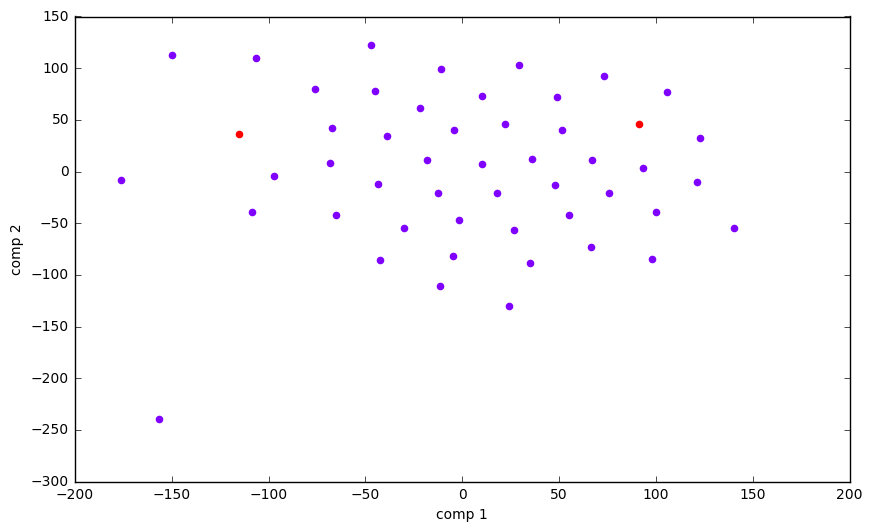

In [33]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, cluster_num))
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
points = tsne.fit_transform(X)
plt.figure(figsize=(10, 6))
plt.xlabel('comp 1')
plt.ylabel('comp 2')
for p_c in zip(points,  colors[y]):
    plt.scatter(p_c[0][0], p_c[0][1], color=p_c[1])

# Dataframe save and load

In [34]:
predicted_df.write.save("df-result", mode="overwrite", format="parquet")

In [35]:
from pyspark.sql import DataFrameReader

loaded_df = spark.read.load("df-result")

In [36]:
loaded_df.show(5)

+--------+------------------+------------------+------------------+------------------+--------------------+--------------------+----------+
|actor_id|       cctxn_score|         atm_score|         cti_score|      mybank_score|            features|     scaled_features|prediction|
+--------+------------------+------------------+------------------+------------------+--------------------+--------------------+----------+
|      16| 3.135498563745785| 3.135498563745785| 2.944444242310485| 3.465739027794844|[3.13549856374578...|[0.03776650618432...|         0|
|      30|2.6390644724468912| 4.330734656074939|2.6390644724468912| 3.258100384167932|[2.63906447244689...|[-0.1464813531569...|         0|
|      41| 3.135498563745785| 3.135498563745785| 2.944444242310485| 3.465739027794844|[3.13549856374578...|[0.03776650618432...|         0|
|       5|2.6390644724468912| 4.330734656074939|2.6390644724468912| 3.258100384167932|[2.63906447244689...|[-0.1464813531569...|         0|
|      13|2.07945404

# Thanks for your attending HackNTU X Cathay 2017!